In [24]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
dataset_path = '/content/drive/My Drive/CVPR/animal_dataset'

X = []
y = []


try:
    all_items = os.listdir(dataset_path)
    categories = sorted([item for item in all_items if os.path.isdir(os.path.join(dataset_path, item))])
    print(f"Found {len(categories)} classes: {categories}")
except FileNotFoundError:
    print("Error: Dataset path not found. Please check your Drive path.")
    categories = []


for label_name in categories:
    folder_path = os.path.join(dataset_path, label_name)
    print(f"Processing folder: {label_name}...")

    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)

        img = cv2.imread(img_path)
        if img is not None:

            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (32, 32))

            X.append(resized.flatten())
            y.append(label_name)

X = np.array(X)
y = np.array(y)

print(f"Data ready. Shape: {X.shape}")

Found 3 classes: ['cat', 'dog', 'panda']
Processing folder: cat...
Processing folder: dog...
Processing folder: panda...
Data ready. Shape: (300, 1024)


In [26]:
def predict_knn_vectorized(X_train, y_train, X_test, k, metric='l2'):
    """
    Predicts labels using vectorized distance calculations.
    """
    predictions = []

    for test_point in X_test:

        if metric == 'l1':

            distances = np.sum(np.abs(X_train - test_point), axis=1)

        else:
            distances = np.sqrt(np.sum((X_train - test_point)**2, axis=1))


        sorted_indices = np.argsort(distances)

        nearest_indices = sorted_indices[:k]

        nearest_labels = y_train[nearest_indices]

        vote = Counter(nearest_labels).most_common(1)[0][0]
        predictions.append(vote)

    return np.array(predictions)

Starting Vectorized Cross-Validation...


Testing K: 100%|██████████| 20/20 [00:03<00:00,  5.66it/s]


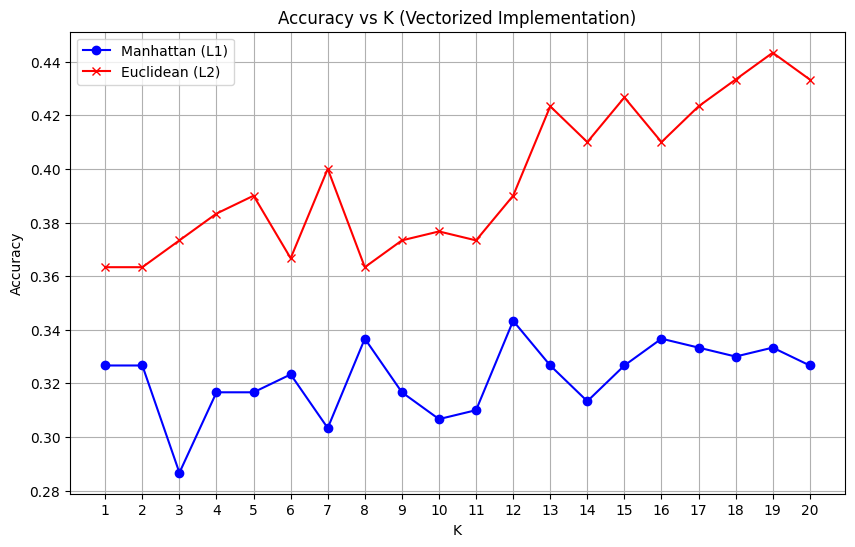

In [27]:

indices = np.arange(len(X))
np.random.shuffle(indices)
X_shuffled = X[indices]
y_shuffled = y[indices]

folds = np.array_split(indices, 5)

k_values = range(1, 21)
acc_manhattan = []
acc_euclidean = []

print("Starting Vectorized Cross-Validation...")

for k in tqdm(k_values, desc="Testing K"):
    fold_l1 = []
    fold_l2 = []

    for i in range(5):

        val_idx = folds[i]
        train_idx = np.concatenate([folds[j] for j in range(5) if j != i])

        X_tr, y_tr = X_shuffled[train_idx], y_shuffled[train_idx]
        X_val, y_val = X_shuffled[val_idx], y_shuffled[val_idx]

        pred_l1 = predict_knn_vectorized(X_tr, y_tr, X_val, k, metric='l1')
        pred_l2 = predict_knn_vectorized(X_tr, y_tr, X_val, k, metric='l2')

        fold_l1.append(np.mean(pred_l1 == y_val))
        fold_l2.append(np.mean(pred_l2 == y_val))

    acc_manhattan.append(np.mean(fold_l1))
    acc_euclidean.append(np.mean(fold_l2))

# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(k_values, acc_manhattan, 'b-o', label='Manhattan (L1)')
plt.plot(k_values, acc_euclidean, 'r-x', label='Euclidean (L2)')
plt.title('Accuracy vs K (Vectorized Implementation)')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()

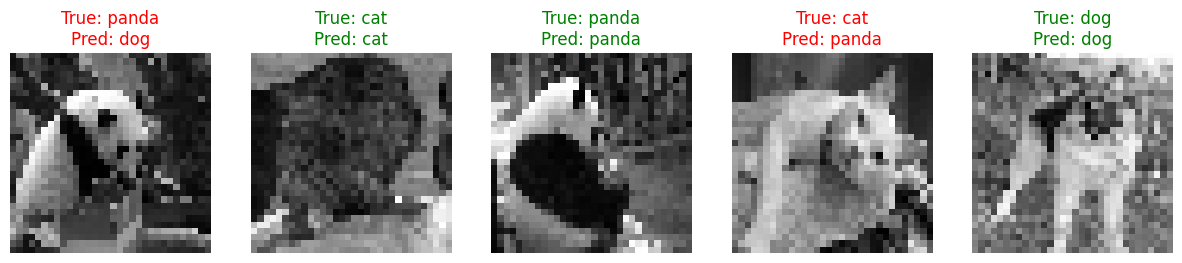

In [28]:

final_k = 5

rand_idx = np.random.choice(len(X), 5, replace=False)
X_sample = X[rand_idx]
y_sample = y[rand_idx]

mask = np.ones(len(X), dtype=bool)
mask[rand_idx] = False
X_train_final = X[mask]
y_train_final = y[mask]

# Predict
preds = predict_knn_vectorized(X_train_final, y_train_final, X_sample, final_k, metric='l2')

plt.figure(figsize=(15, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)

    plt.imshow(X_sample[i].reshape(32, 32), cmap='gray')

    color = 'green' if preds[i] == y_sample[i] else 'red'
    plt.title(f"True: {y_sample[i]}\nPred: {preds[i]}", color=color)
    plt.axis('off')

plt.show()